# Zero-inflated Poisson distribution

* $\pi$ is the probability of extra zeros

In [1]:
# Import the required libraries
library(ggplot2)
library(rjags)
library(MCMCvis)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=8, repr.plot.height=4)

Warning message:
"package 'ggplot2' was built under R version 3.5.3"Warning message:
"package 'rjags' was built under R version 3.5.3"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.5.3"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs
Warning message:
"package 'MCMCvis' was built under R version 3.5.3"

## Generating samples from a Zero-inflated Poisson distribution

In [2]:
generate_zip_samples = function(pi, lam, N) {
    # Generate samples from a Zero-Inflated Poisson (ZIP) distribution
    #
    # Args:
    #   pi: Probability of a zero.
    #   lam: Mean of the Poisson distribution.
    #   N: Number of samples to generate.
    #
    # Returns:
    #   N samples from a Zero-Inflated Poisson distribution.
    
    # Preconditions
    stopifnot(0 <= pi && pi <= 1)
    stopifnot(lam > 0)
    stopifnot(N >= 0)
    
    # Vector of the mixture from which the sample will be drawn
    mixture = rbinom(N, 1, 1-pi)
    
    # Generate samples from a Poisson distribution
    comp_poisson = rpois(N, lam)
    
    # Generate samples from the zero distributiokn
    comp_zeros = rep(0, N)
    
    # Generate and return the mixture
    mixture * comp_zeros + mixture * comp_poisson
}

# Tests
stopifnot(length(generate_zip_samples(1,6,10)) == 10)
stopifnot(all(generate_zip_samples(1, 3, 10) == 0))

In [3]:
# Probability of extra zeros
pi = 0.6

# Mean of the Poisson distribution
lam = 5

# Number of samples
N = 10

# Generate the samples
samples = generate_zip_samples(pi, lam, N)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


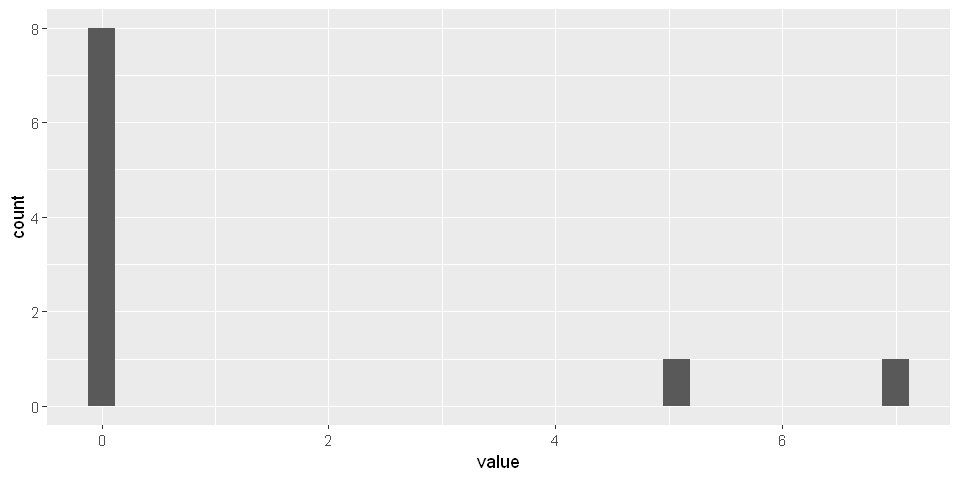

In [4]:
# Plot a histogram of the values

# Create a dataframe of the values
df = data.frame(value=samples)

# Generate the histogram
ggplot(df, aes(x=value)) + geom_histogram()

## Generating samples from a Zero-inflated Poisson distribution using JAGS

In the previous section, samples from the Zero-Inflated Poisson distribution were generated using R. In this section, JAGS will be used for generation.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 20
   Total graph size: 65

Initializing model



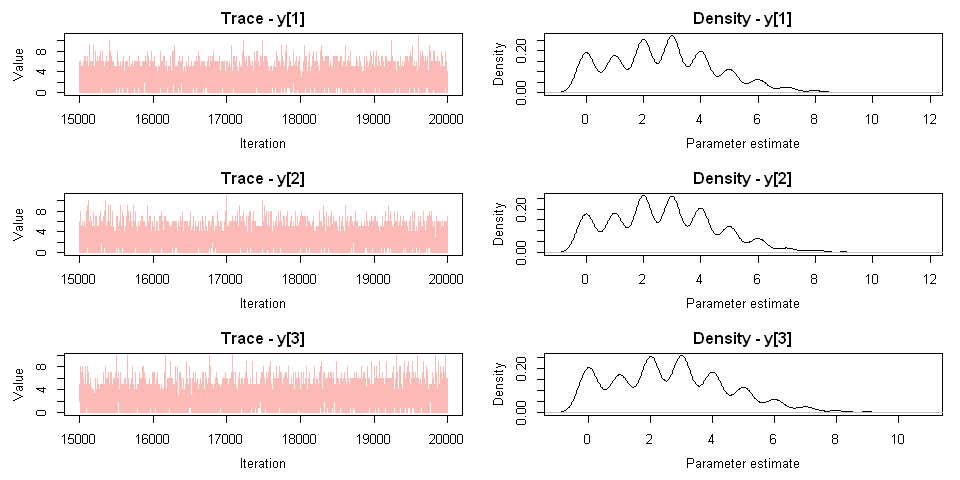

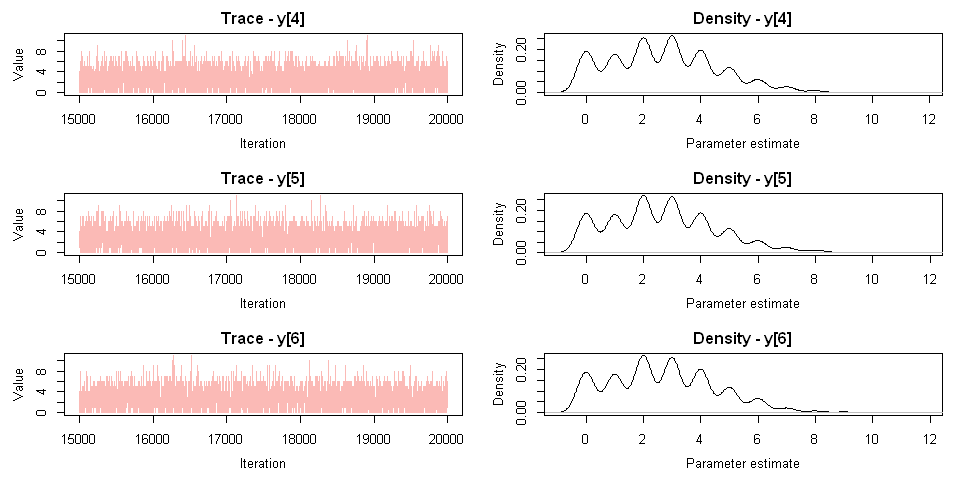

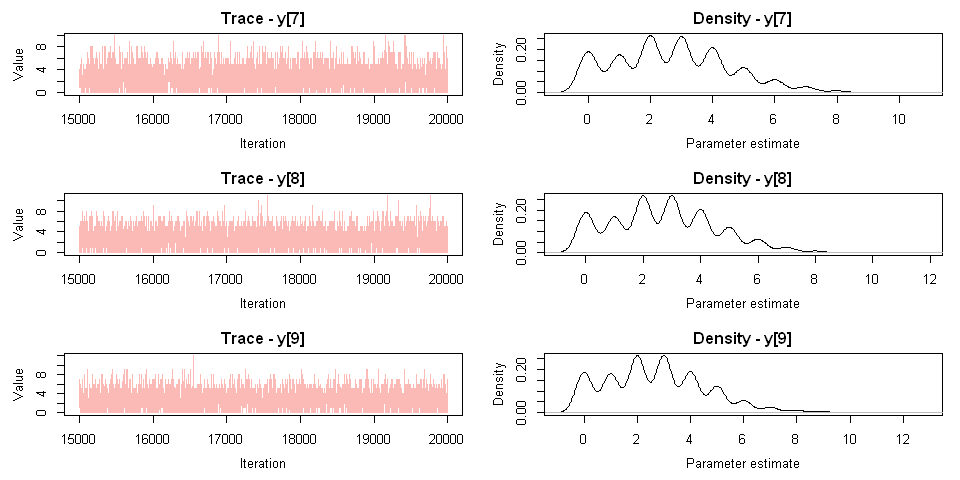

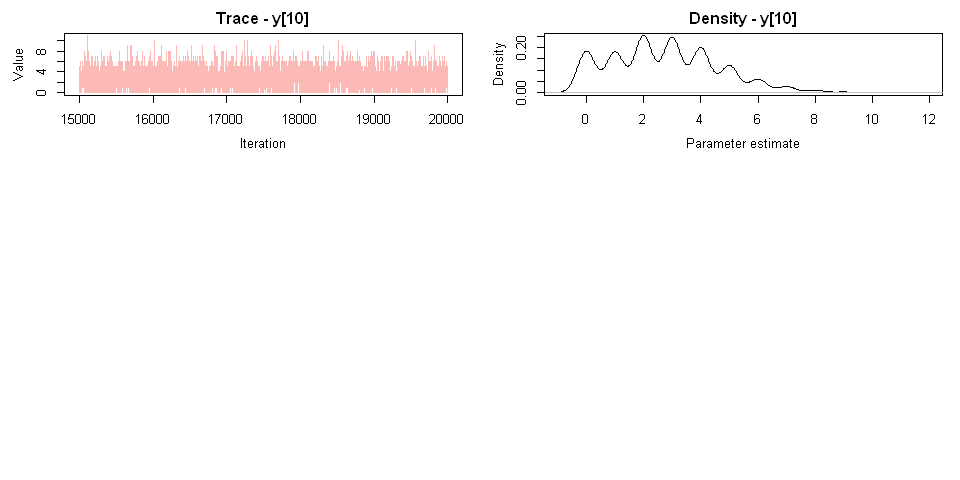

In [5]:
# Generate samples from the Zero-Inflated Poisson distribution using JAGS
# Known:
#   pi (probability of a zero)
#   lambda (mean of the Poisson distribution)

model_string = "
model {

    # Likelihood
    for (i in 1:N) {

        # Is the sample drawn from the zero-inflated part?
        zero[i] ~ dbern(pi)  # 1=>zero-inflated, 0=>poisson

        # Lambda of the Poisson distribution (the 1e-10 is because a value of zero won't work)
        lambda_zip[i] <- ((1-zero[i]) * lambda) + (zero[i] * 1e-10)

        # Sample from the Poisson distribution where the mean has been 'modulated'
        y[i] ~ dpois(lambda_zip[i])
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(N=10, pi=0.1, lambda=3))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("y"), 
                     n.iter=20000, progress.bar="none")

MCMCtrace(samp, 
          pdf=FALSE)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


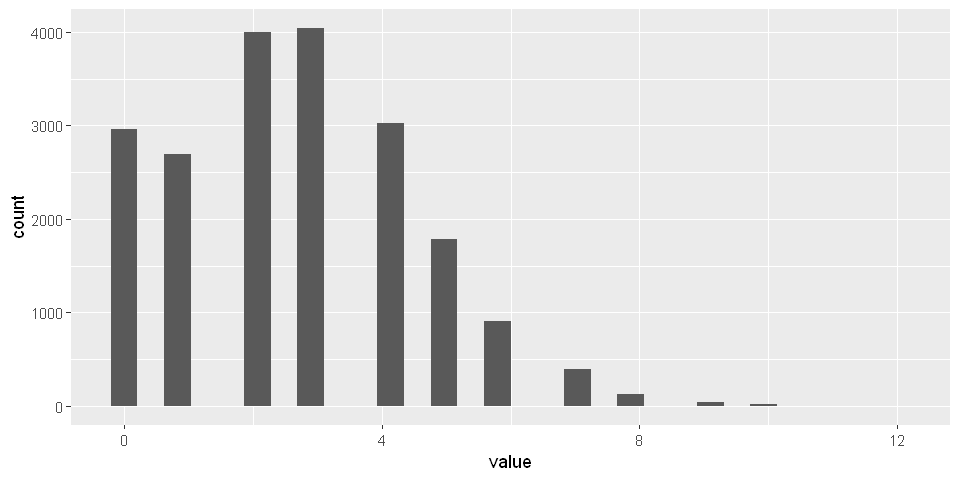

In [6]:
# Plot a histogram of a single sample
single_sample = as.matrix(samp)[,1]

# Create a dataframe of the values
df = data.frame(value=single_sample)

# Generate the histogram
ggplot(df, aes(x=value)) + geom_histogram()

## Inferring the parameters of a Zero-inflated Poisson distribution

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10
   Unobserved stochastic nodes: 12
   Total graph size: 66

Initializing model



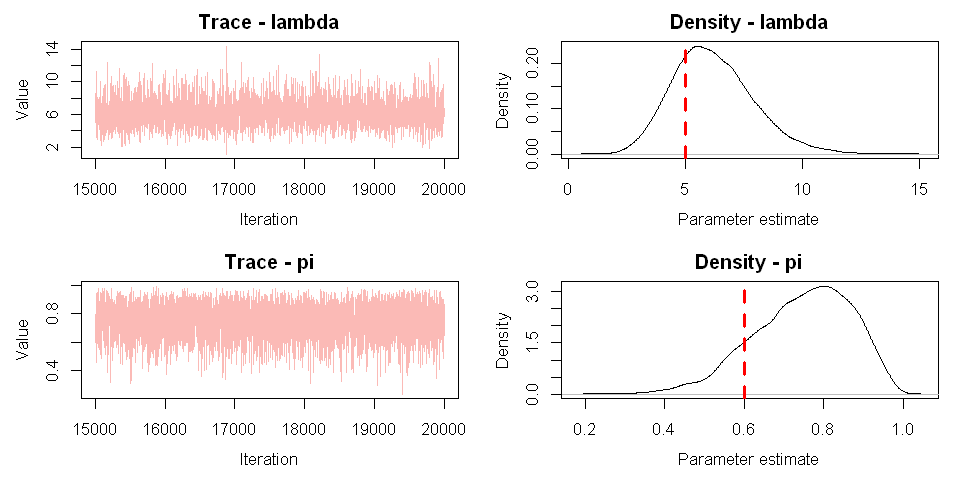

In [7]:
# Infer the parameters of the Zero-Inflated Poisson distribution using JAGS

model_string = "
model {

    # Prior
    pi ~ dbeta(1,1)
    lambda ~ dexp(0.1)

    # Likelihood
    for (i in 1:N) {

        # Is the sample drawn from the zero-inflated part?
        zero[i] ~ dbern(pi)  # 1=>zero-inflated, 0=>poisson

        # Lambda of the Poisson distribution (the 1e-10 is because a value of zero won't work)
        lambda_zip[i] <- ((1-zero[i]) * lambda) + (zero[i] * 1e-10)

        # Sample from the Poisson distribution where the mean has been 'modulated'
        y[i] ~ dpois(lambda_zip[i])
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(N=length(samples), y=samples))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("lambda", "pi"), 
                     n.iter=20000, progress.bar="none")

gv = c(lam, pi)
MCMCtrace(samp, 
          gv=gv,
          pdf=FALSE)